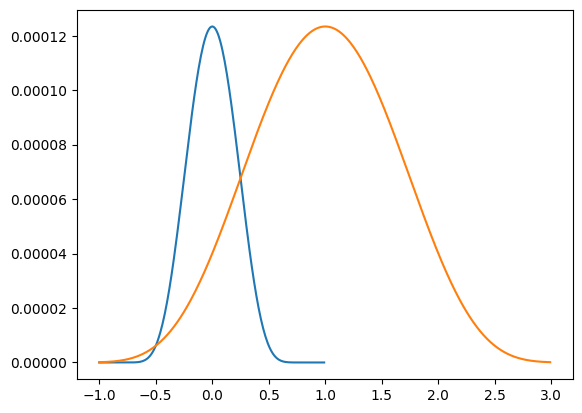

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp


# Test function: This is centered at 0
def phi(t, r=2, c=0):
    return np.exp(
        -9 / np.maximum((1 - ((t - c) / r) ** 2), 1e-10)

    )  # We use 1e-10 instead of 0, otherwise we divide by 0


t = np.arange(-1, 1, 0.01)

plt.clf()
plt.plot(t, phi(t, r=1))
# What about a different centeringp?
t = np.arange(-1, 3, 0.01)
plt.plot(t, phi(t, r=3, c=1))

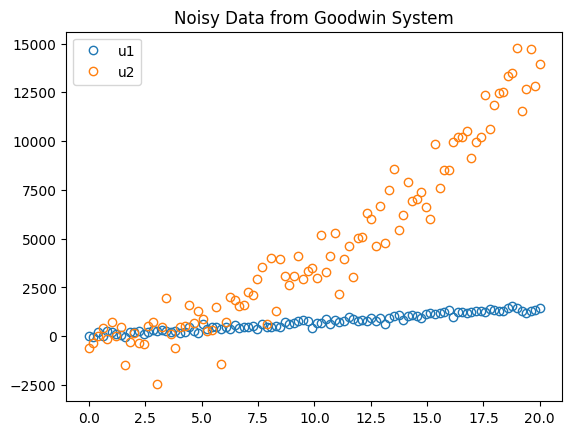

In [8]:
def goodwin_2d(t, u, p):
    """
    Goodwin 2D oscillator system
    u1' = p1 - p3/(36 + p2*u2)
    u2' = p4*u1 - p5
    """
    u1, u2 = u
    p1, p2, p3, p4, p5 = p

    du1dt = p1 - p3 / (36 + p2 * u2)
    du2dt = p4 * u1 - p5

    return [du1dt, du2dt]


npoints = 100
t_span = [0, 20]
t_eval = np.linspace(t_span[0], t_span[1], npoints)
u0 = [7, -10]
p_star = [72, 1, 2, 1, 1]

sol = solve_ivp(
    goodwin_2d,
    t_span,
    u0,
    args=(p_star,),
    dense_output=True,
    rtol=1e-8,
    atol=1e-10,

    t_eval=t_eval,
)

t = sol.t
u1_star = sol.y[0]
u2_star = sol.y[1]

# Generate some noise proportional to the data
noise_ratio = 0.05
mean = np.array([0.0, 0.0])
cov = np.diag([noise_ratio * np.var(u1_star), noise_ratio * np.var(u2_star)])
noise = np.random.multivariate_normal(mean, cov, size=npoints)

e1 = [x[0] for x in noise]
e2 = [x[1] for x in noise]

u1 = u1_star + e1
u2 = u2_star + e2

plt.clf()
plt.title("Noisy Data from Goodwin System")
plt.plot(t, u1, marker="o", linestyle="None", markerfacecolor="none", label="u1")
plt.plot(t, u2, marker="o", linestyle="None", markerfacecolor="none", label="u2")

plt.legend()

In [41]:
print('hello world')

hello world


In [167]:
# In practice this is what we will use
def phi(t, eta=9):
    return np.exp(-eta * (1 - t ** 2) ** (-1 + 1e-10))


In [196]:
def sanitize_radius_params(U, tt, radius_min_time=0.01, radius_max_time=5, radius_params=np.linspace(1, 12, 12)):
    len_tt = len(tt)  # length of time array
    dt = np.mean(np.diff(tt))
    radius_interior_domain = int(np.floor((len_tt - 2) / 2))  # radius as number of data points
    radius_max = int(np.ceil(radius_max_time / dt)) # max input radius as the number of data points
    radius_min = int(max(np.ceil(radius_min_time / dt), 1))  # Min radius of 1 for now

    if radius_max > radius_interior_domain:
        radius_max = radius_interior_domain

    return([radius_min, radius_max, radius_params])


def build_test_function_matrix(n_radius, tt, n_test_functions=None):
    len_tt = len(tt)
    n_diameter = 2 * n_radius + 1

    # diameter can't be larger than the domain
    if n_diameter > len_tt - 2:
        n_radius = int(np.floor((len_tt - 2) / 2))

    indices = build_test_function_support_indices(
        n_radius, n_test_functions, len_tt
    )

    V = np.zeros((len(indices), len_tt))

    xx = np.linspace(-1, 1, n_diameter + 2)[1:-1] # Don't include the endpoints (support is zero & this is used in build_test_function_support_indicies)
    v_rowk = phi(xx) / np.linalg.norm(phi(xx), ord=2)  # For stability

    for i, support_indices in enumerate(indices):
        V[i, support_indices] = v_rowk[: len(support_indices)]
    return V


def build_test_function_support_indices(radius, n_test_functions, len_tt):
    n_diameter = 2 * radius + 1
    n_interior = len_tt - 2  # Exclude boundaries

    if n_diameter > n_interior:
        raise ValueError("n_diameter must be <= n_interior")

    if n_test_functions is None:
        gap = 1
        n_test_functions = (n_interior - n_diameter) // gap + 1
    else:
        if n_test_functions < 1:
            raise ValueError("n_test_functions must be >= 1")
        if n_test_functions == 1:
            gap = int(np.floor((n_interior - n_diameter) /2))
            print(f"gap: {gap}")
        else:
            max_start = n_interior - n_diameter
            gap = max_start // (n_test_functions - 1)

    indices = []
    for j in range(n_test_functions):
        start = j * gap + 1  # Offset by 1 to skip the boundary
        end = start + n_diameter

        if n_test_functions == 1:
            start = gap
            end = start + n_diameter

        if end > len_tt - 1:
            start = len_tt - 1 - n_diameter
            end = len_tt - 1
        indices.append(list(range(start, end)))

    return indices


n_points = 160
t_span = [0, 80]
tt = np.linspace(t_span[0], t_span[1], n_points)
dt = np.mean(np.diff(tt))
U = np.array([u1, u2]).T

radius_params = np.linspace(1, 12, 12)
# radius_min, radius_max, radius_params = sanitize_radius_params(U, tt, radius_params=radius_params)

radii = radius_params*1
# radii = np.array([r for r in radii if r < radius_max], dtype=int)
print(radii)
V_full = np.vstack([build_test_function_matrix(int(i), tt) for i in radii])
V_full


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


array([[0.00000000e+00, 4.96641155e-02, 9.97530426e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.96641155e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.34006149e-23, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.13613080e-11, 1.34006149e-23, 0.00000000e+00]],
      shape=(1740, 160))